In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
import pyAMARES

Current pyAMARES version is 0.3.5
Author: Jia Xu, MR Research Facility, University of Iowa


# Using AMARES for Post-Processing: Removing Metabolite Residuals from Macromolecule (MM) Spectra

- [Simicic, Dunja, et al. "In vivo macromolecule signals in rat brain 2H-MR spectra at 9.4 T: parametrization, spline baseline estimation, and T2 relaxation times." Magnetic Resonance in Medicine 86.5 (2021): 2384-2401.](https://doi.org/10.1002/mrm.28910) provides an excellent example of removing residual metabolites from short-echo time (TE) <sup>1</sup>H-MR spectra using [jMRUI](http://www.mrui.uab.es/mrui/)  

- We will reproduce the **jMRUI/AMARES** example using pyAMARES:
	- Download example MM spectra and AMARES prior knowledge for jMRUI from the supplementary material here: [Supinfo 2](https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2Fmrm.28910&file=mrm28910-sup-0002-Supinfo2.zip).

	- After downloading `mrm28910-sup-0002-supinfo2.zip`, unzip it. The necessary jMRUI files for removing MM from 1H MRS are located in the folder `Metabolite_removal_PK_SV`.

	- Due to the [CC BY-NC-ND 4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/) under which the paper is published, we do not provide the files in the pyAMARES GitHub repository. Please download them directly from the URLs mentioned above, which link to the supplementary information (SI) of the paper [Simicic et al](https://doi.org/10.1002/mrm.28910).

**Load 1H MRS Spectrum in the jMRUI Format Using the spec2nii Tool**

- [spec2nii](https://github.com/wtclarke/spec2nii) can be installed with the command: `pip install spec2nii`

In [2]:
mrui_spectra = 'Data_PK_forSubmission/Metabolite_removal_PK_SV/TE02_MMspectrum.mrui'

In [3]:
from spec2nii import jmrui # Load jmrui module

In [4]:
fid, header, str_info = jmrui.read_mrui('Data_PK_forSubmission/Metabolite_removal_PK_SV/TE02_MMspectrum.mrui')
fid.shape

(4096,)

In [5]:
# Check header information
header

{'type_of_sig': 0.0,
 'number_of_points': 4096,
 'sampling_interval': 0.2,
 'begin_time ': 0.0,
 'zero_order_phs': 0.0,
 'transmitter_frequency': 400265406.1,
 'magnetic_field': 9.4,
 'type_of_nucleus': 0.0,
 'reference_frequency_hz': -1879.846708627255,
 'reference_frequency_ppm': -4.696500571817103,
 'fid_or_echo': 0.0,
 'apodizing': 0.0,
 'num_zeros_view': 0.0}

## Two Methods of Analyzing <sup>1</sup>H MRS Spectrum Using a Reference Peak (Water Peak)


In [6]:
# Obtain spectral parameters required by AMARES from the header:
sw = 1.0 / (header['sampling_interval'] * 1e-3) # 1/dwell 
MHz = header['transmitter_frequency'] * 1e-6
deadtime = header['begin_time ']
sw, MHz, deadtime

(5000.0, 400.2654061, 0.0)

### Method 1 (shif FID): Shift FID to Align the Water Peak at 4.7 ppm

In [7]:
carrier = abs(header['reference_frequency_ppm'])
carrier

4.696500571817103

### Method 2 (shift prior knowledge): Adjust Prior Knowledge by Offsetting the Reference Peak Relative to the Carrier and Center of Readout (Similar to OXSA)

In [8]:
ppm_offset  = header['reference_frequency_ppm'] # -4.7 ppm
ppm_offset

-4.696500571817103

## Prior Knowledge of Residual Metabolites 

**Visualizing Screenshots of jMRUI/AMARES Prior Knowledge Files**

- Initial Values

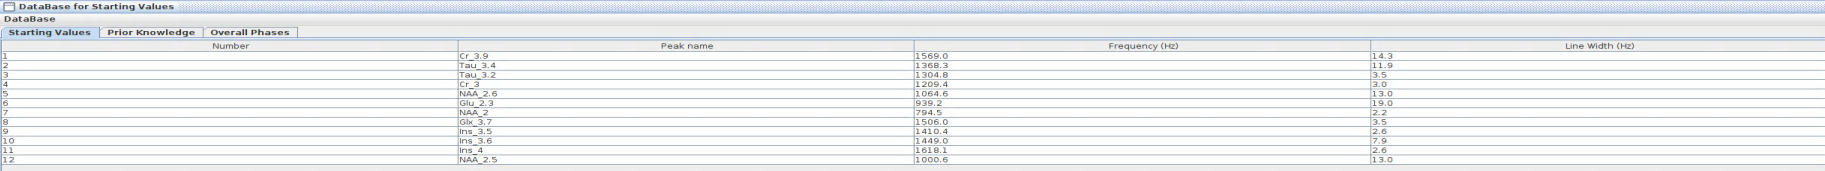

In [9]:
Image('../images/SV.png')

- Constraints 

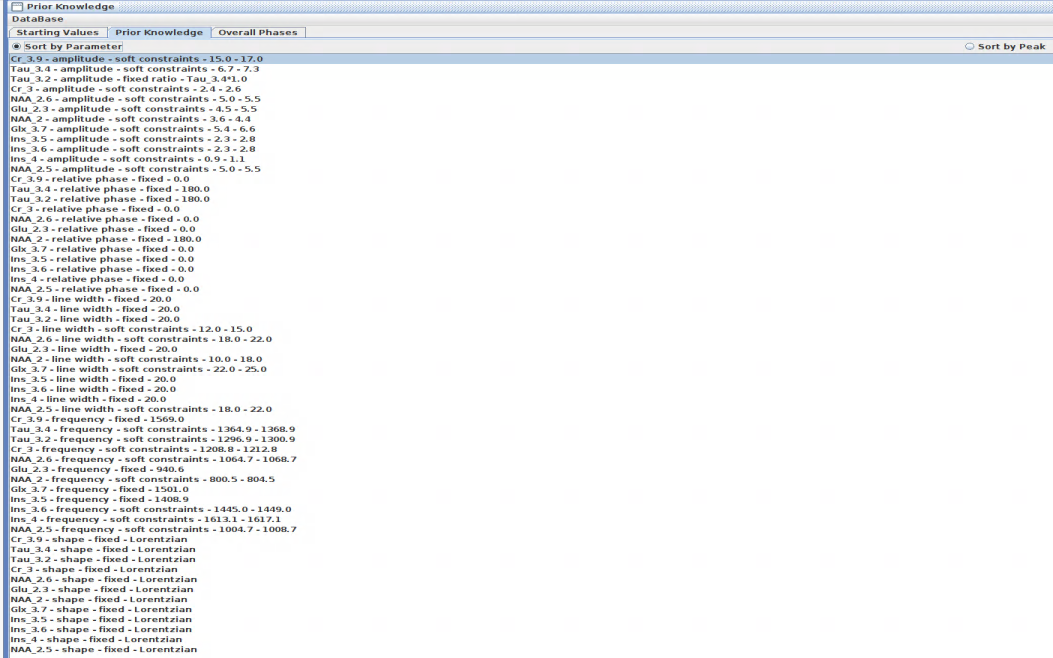

In [10]:
Image('../images/PK.png')

- Overall Phases

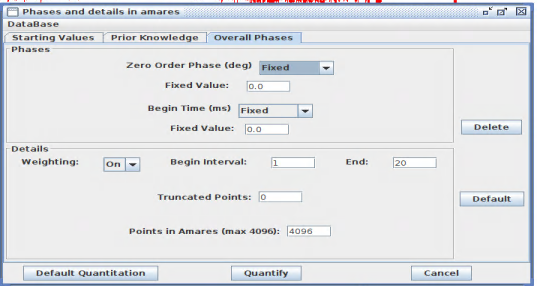

In [11]:
Image('../images/phase.png')

**Visualizing pyAMARES Prior Knowledge Converted from jMRUI's StartingValues.sv, PriorKnowledge.pk, and OverallPhases.op**

In [12]:
PKfilename = 'attachment/Table1.csv' # Prior Knowledge, a combination of  in pyAMARES format 

In [13]:
pk = pd.read_csv(PKfilename)
pk

,Index,Cr_a,Cr_b,Glu,Glx,Ins,Ins2,Ins_b,NAA_a,NAA,NAA2,Tau,Tau2
0,Initial Values,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,amplitude,2.5,16,5,6,2.55,Ins,1,4,5.25,NAA,7,Tau
2,chemicalshift,3.021495192,3.92,2.346443099,3.762503522,3.523661997,3.62009801,4.042567695,1.984932967,2.499841317,2.659735225,3.259837048,3.418481785
3,linewidth,3,14.3,19,3.5,2.6,7.9,2.6,2.2,13,NAA,3.5,Tau
4,phase,0,0,0,0,0,0,0,0,0,0,180,180
5,g,0,0,0,0,0,0,0,0,0,0,0,0
6,Bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,amplitude,"(2.4, 2.6)","(15.0, 17.0)","(4.5, 5.5)","(5.4, 6.6)","(2.3, 2.8)","(2.3, 2.8)","(0.9, 1.1)","(3.6, 4.4)","(5.0, 5.5)","(5.0, 5.5)","(6.7, 7.3)","(6.7, 7.3)"
8,chemicalshift,"(3.02, 3.03)",3.92,2.35,3.75,3.52,"(3.61, 3.62)","(4.03, 4.04)","(2.0, 2.01)","(2.51, 2.52)","(2.66, 2.67)","(3.41, 3.42)","(3.24, 3.25)"
9,linewidth,"(12, 15)",20,20,"(22,25)",20,20,20,"(10, 18)","(18.0, 22.0)","(18.0, 22.0)",20,20


**Weighting the First 20 Points of an FID Similarly to jMRUI**

In [14]:
def Weighting(fid, BeginInterval=0, End=20):
    """
    Applies a quarter-sine wave weighting to the first points of a FID. 
    This function mimics JMRUI's Weighting but Python uses 0-based indexing. 

    Args:
        fid (numpy.ndarray): The 1D FID signal array to be weighted.
        BeginInterval (int, optional): The starting index for apodization in the FID. Defaults to 0.
        End (int, optional): The ending index for apodization in the FID. If not specified, weighting 
                             applies until the 20th point.

    Returns:
        tuple:
            - numpy.ndarray: The weighted FID. 
            - numpy.ndarray: The array of weights applied to the FID

    Note:
        - The 1D array `apod` refers to the weighting applied to an FID. Note the residual from 
        jMRUI's AMARES appears unapodized, even if the FID has been previously weighted prior to 
        AMARES quantitation by jMRUI. Thus, `apod` is used to weight the residual returned by 
        jMRUI/AMARES, allowing for direct comparison with the residual generated by pyAMARES.
    """
    weight = np.sin(np.linspace(0, np.pi/2, End - BeginInterval))
    apod = np.ones(fid.shape)
    apod[BeginInterval:End] = weight
    return fid * apod, apod

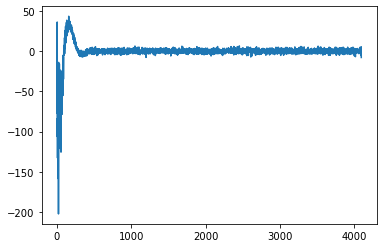

In [15]:
fid2, apod = Weighting(fid, BeginInterval=0, End=20)
plt.plot(fid2.real)

## AMARES Fitting (Method 1): 
- **Shift the FID so the Water Peak is at 4.7 ppm** 

- Load prior knowledge and initialize the FID object.

Shift FID so that center frequency is at 4.696500571817103 ppm!
Checking comment lines in the prior knowledge file
Comment: in line 13 # Index of JMRUI,Cr_3,Cr_3.9,Glu_2.3,Glx_3.7,Ins_3.5,Ins_3.6,Ins_4,NAA_2,NAA_2.5,NAA_2.6,Tau_3.4,Tau_3.2



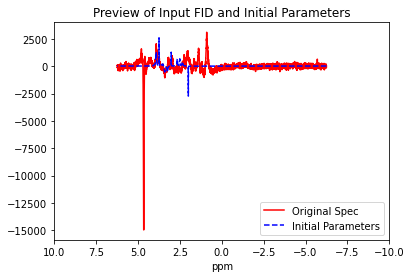

Printing the Prior Knowledge File attachment/Table1.csv


,Cr_a,Cr_b,Glu,Glx,Ins,Ins2,Ins_b,NAA_a,NAA,NAA2,Tau,Tau2
Index,,,,,,,,,,,,
Initial Values,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,2.5,16,5,6,2.55,Ins,1,4,5.25,NAA,7,Tau
chemicalshift,3.021495,3.92,2.346443,3.762504,3.523662,3.620098,4.042568,1.984933,2.499841,2.659735,3.259837,3.418482
linewidth,3,14.3,19,3.5,2.6,7.9,2.6,2.2,13,NAA,3.5,Tau
phase,0,0,0,0,0,0,0,0,0,0,180,180
g,0,0,0,0,0,0,0,0,0,0,0,0
Bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,"(2.4, 2.6)","(15.0, 17.0)","(4.5, 5.5)","(5.4, 6.6)","(2.3, 2.8)","(2.3, 2.8)","(0.9, 1.1)","(3.6, 4.4)","(5.0, 5.5)","(5.0, 5.5)","(6.7, 7.3)","(6.7, 7.3)"
chemicalshift,"(3.02, 3.03)",3.92,2.35,3.75,3.52,"(3.61, 3.62)","(4.03, 4.04)","(2.0, 2.01)","(2.51, 2.52)","(2.66, 2.67)","(3.41, 3.42)","(3.24, 3.25)"


In [16]:
FIDobj = pyAMARES.initialize_FID(fid=fid2,
        priorknowledgefile=PKfilename,
        preview=True, 
        xlim=(10,-10), # Set a wide spectrum width to check if flip_axis is necessary.
        MHz=MHz, 
        sw=sw, 
        deadtime=deadtime, 
        carrier=carrier, # Set water peak at 4.7 ppm.
        ppm_offset=0.0, # Note: ppm_offset is disabled.
        flip_axis=True,
        normalize_fid=False, 
        noise_var='jMRUI') # Uses jMRUI's default method for noise variance estimation,
                           # which calculates noise using the last 10% of points in the FID.
                           # By default, pyAMARES employs OXSA's strategy, estimating noise from
                           # the residual. However, in this case, where the residual is the 
                           # MM spectrum itself, it is not suitable for noise variance estimation.


- Initialization Using Levenberg-Marquardt Method:

In [17]:
FIDresult1 = pyAMARES.fitAMARES(fid_parameters=FIDobj, fitting_parameters=FIDobj.initialParams,
                       method='leastsq', ifplot=False,
                       inplace=False)

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 1.376e-05


Fitting with method=leastsq took 6.727328 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by jMRUI.
a_sd is all None, use crlb instead!
freq_sd is all None, use crlb instead!
lw_sd is all None, use crlb instead!
phase_sd is all None, use crlb instead!
g_std is all None, use crlb instead!
Norm of residual= 1250021.690
Norm of the data=1268915.419
resNormSq / dataNormSq = 0.985


- Fitting AMARES Using Levenberg-Marquardt-Initialized Parameters:

In [18]:
FIDresult1b = pyAMARES.fitAMARES(fid_parameters=FIDresult1, fitting_parameters=FIDresult1.fittedParams,
                       method='least_squares', ifplot=False,
                       inplace=False)

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 1.376e-05


Fitting with method=least_squares took 1.022673 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by jMRUI.
Norm of residual= 1247564.390
Norm of the data=1268915.419
resNormSq / dataNormSq = 0.983


- Visualize the fitting results.

In [19]:
plotParameters = FIDresult1b.plotParameters
plotParameters.xlim=(4.2,-0.2) # Set xlimi to 4.2 to -0.2 ppm

fitting_parameters is None, just use the fid_parameters.out_obj.params


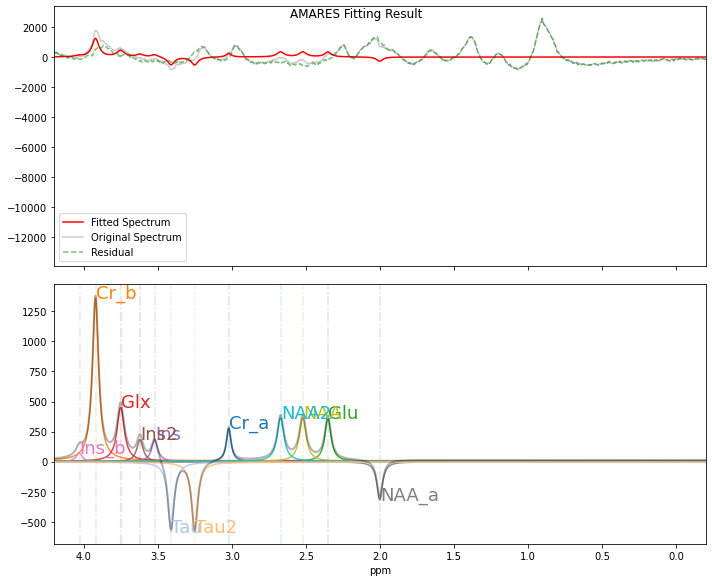

In [20]:
pyAMARES.plotAMARES(fid_parameters=FIDresult1b, plotParameters=plotParameters)

## AMARES Fitting (Method 2): 
- **Use the offset between the reference peak and carrier versus the center of readout to shift the chemical shift of peaks in prior knowledge. This method will shift peak positions by `ppm_offset`.**


- Load prior knowledge and initialize the FID object.

Checking comment lines in the prior knowledge file
Comment: in line 13 # Index of JMRUI,Cr_3,Cr_3.9,Glu_2.3,Glx_3.7,Ins_3.5,Ins_3.6,Ins_4,NAA_2,NAA_2.5,NAA_2.6,Tau_3.4,Tau_3.2

Shifting the ppm by ppm_offset=-4.70 ppm
before opts.initialParams[freq_Cr_a].value=1209.4000000550775
new value should be opts.initialParams[freq_Cr_a].value + opts.ppm_offset * opts.MHz=-670.4467085721776
after opts.initialParams[freq_Cr_a].value=-670.4467085721776
before opts.initialParams[freq_Cr_b].value=1569.040391912
new value should be opts.initialParams[freq_Cr_b].value + opts.ppm_offset * opts.MHz=-310.8063167152552
after opts.initialParams[freq_Cr_b].value=-310.8063167152552
before opts.initialParams[freq_Glu].value=940.6237043350001
new value should be opts.initialParams[freq_Glu].value + opts.ppm_offset * opts.MHz=-939.223004292255
after opts.initialParams[freq_Glu].value=-939.223004292255
before opts.initialParams[freq_Glx].value=1500.995272875
new value should be opts.initialParams[freq_Glx].value

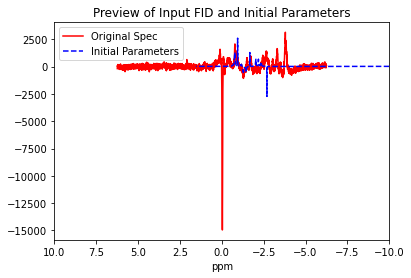

Printing the Prior Knowledge File attachment/Table1.csv


,Cr_a,Cr_b,Glu,Glx,Ins,Ins2,Ins_b,NAA_a,NAA,NAA2,Tau,Tau2
Index,,,,,,,,,,,,
Initial Values,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,2.5,16,5,6,2.55,Ins,1,4,5.25,NAA,7,Tau
chemicalshift,3.021495,3.92,2.346443,3.762504,3.523662,3.620098,4.042568,1.984933,2.499841,2.659735,3.259837,3.418482
linewidth,3,14.3,19,3.5,2.6,7.9,2.6,2.2,13,NAA,3.5,Tau
phase,0,0,0,0,0,0,0,0,0,0,180,180
g,0,0,0,0,0,0,0,0,0,0,0,0
Bounds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amplitude,"(2.4, 2.6)","(15.0, 17.0)","(4.5, 5.5)","(5.4, 6.6)","(2.3, 2.8)","(2.3, 2.8)","(0.9, 1.1)","(3.6, 4.4)","(5.0, 5.5)","(5.0, 5.5)","(6.7, 7.3)","(6.7, 7.3)"
chemicalshift,"(3.02, 3.03)",3.92,2.35,3.75,3.52,"(3.61, 3.62)","(4.03, 4.04)","(2.0, 2.01)","(2.51, 2.52)","(2.66, 2.67)","(3.41, 3.42)","(3.24, 3.25)"


In [21]:
FIDobj2 = pyAMARES.initialize_FID(fid=fid2,
                 priorknowledgefile=PKfilename,
                 preview=True, 
                 xlim=(10,-10), # Set a wide spectrum width to assess if flip_axis is required.
                 MHz=MHz, 
                 sw=sw, 
                 deadtime=deadtime, 
                 carrier=0.0, # Carrier frequency is set to 0.0 ppm.
                 ppm_offset=ppm_offset, # ppm_offset is adjusted to -4.7 ppm.
                 flip_axis=True,
                 normalize_fid=False, 
                 noise_var='jMRUI') # Uses jMRUI's default method for noise variance estimation.

- Initialization Using Levenberg-Marquardt Method:

In [22]:
FIDresult2 = pyAMARES.fitAMARES(fid_parameters=FIDobj2, fitting_parameters=FIDobj2.initialParams,
                       method='leastsq', ifplot=False,
                       inplace=False)

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 7.156e-06
Fitting with method=leastsq took 6.562004 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by jMRUI.
a_sd is all None, use crlb instead!
freq_sd is all None, use crlb instead!
lw_sd is all None, use crlb instead!
phase_sd is all None, use crlb instead!
g_std is all None, use crlb instead!
Norm of residual= 1250420.864
Norm of the data=1253689.258
resNormSq / dataNormSq = 0.997


- Fitting AMARES Using Levenberg-Marquardt-Initialized Parameters:

In [23]:
FIDresult2b = pyAMARES.fitAMARES(fid_parameters=FIDresult2, fitting_parameters=FIDresult2.fittedParams,
                       method='least_squares', ifplot=False,
                       inplace=False)

A copy of the input fid_parameters will be returned because inplace=False
Autogenerated tol is 7.156e-06
Fitting with method=least_squares took 1.431434 seconds
Estimated CRLBs are calculated using the default noise variance estimation used by jMRUI.
Norm of residual= 1247563.979
Norm of the data=1253689.258
resNormSq / dataNormSq = 0.995


### Compare the Fitted Results
#### Method 1 (Shift FID):

In [24]:
FIDresult1b.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%)
name,,,,,,,,,,,,,,,
Cr_a,2.600,2.396,15.351,3.020,0.017,0.095,14.998,19.583,21.755,0.000,0.000,nan,0.000,0.000,nan
Cr_b,17.000,2.029,1.988,3.920,0.000,0.000,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
Glu,4.500,1.978,7.323,2.350,0.000,0.000,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
Glx,6.600,3.182,8.033,3.750,0.000,0.000,23.445,15.864,11.274,0.000,0.000,nan,0.000,0.000,nan
Ins,4.600,2.656,9.619,3.520,0.000,0.000,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
Ins_b,0.900,1.984,36.736,4.030,0.077,0.319,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
NAA_a,3.600,2.609,12.073,2.000,0.016,0.137,17.997,18.520,17.146,180.000,0.000,0.000,0.000,0.000,nan
NAA,10.000,3.508,5.844,2.520,0.016,0.106,22.000,11.815,8.948,0.000,0.000,nan,0.000,0.000,nan
Tau,14.600,2.666,3.043,3.410,0.010,0.046,20.000,0.000,0.000,180.000,0.000,0.000,0.000,0.000,nan


#### Method 2 (Shift Prior Knowledge):

**Note:** The results from Method 2 are nearly identical to those from Method 1, except that the chemical shifts (in ppm) are adjusted by `ppm_offset`.

In [25]:
FIDresult2b.styled_df

,amplitude,sd,CRLB(%),chem shift(ppm),sd(ppm),CRLB(cs%),LW(Hz),sd(Hz),CRLB(LW%),phase(deg),sd(deg),CRLB(phase%),g,g_sd,g (%)
name,,,,,,,,,,,,,,,
Cr_a,2.600,2.396,15.437,-1.677,0.017,0.173,15.000,19.587,21.877,0.000,0.000,nan,0.000,0.000,nan
Cr_b,17.000,2.029,2.000,-0.777,0.000,0.000,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
Glu,4.500,1.978,7.363,-2.347,0.000,0.000,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
Glx,6.600,3.192,8.103,-0.947,0.000,0.000,23.564,15.994,11.371,0.000,0.000,nan,0.000,0.000,nan
Ins,4.600,2.657,9.676,-1.177,0.000,0.000,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
Ins_b,0.900,1.984,36.939,-0.667,0.077,1.941,20.000,0.000,0.000,0.000,0.000,nan,0.000,0.000,nan
NAA_a,3.600,2.609,12.140,-2.697,0.016,0.102,18.000,18.525,17.242,180.000,0.000,0.000,0.000,0.000,nan
NAA,10.000,3.508,5.876,-2.177,0.016,0.123,22.000,11.816,8.997,0.000,0.000,nan,0.000,0.000,nan
Tau,14.600,2.666,3.059,-1.287,0.010,0.124,20.000,0.000,0.000,180.000,0.000,0.000,0.000,0.000,nan


## Compare to jMRUI Results:
- Load jMRUI results 
- Both json and Detailed Results are loaded for peak names and the fitted results. 

In [26]:
import json
with open('attachment/20240519_weighted.json') as f:
    d = json.load(f)

In [27]:
detailedresults = pd.read_csv('attachment/DetailedResults.csv')
detailedresults

,Number,Freq. (ppm),sd Freq.(ppm),Sp. Width (Hz),sd Sp. Width (Hz),Amplitude,sd Ampl.,Phase (deg),sd Ph.(deg)
0,1,3.92,0.000000,20.00,0.00,17.00,0.3865,0,0
1,2,3.41,0.001601,20.00,0.00,7.30,0.3066,180,0
2,3,3.25,0.001594,20.00,0.00,7.30,0.3066,180,0
3,4,3.02,0.002904,15.00,3.69,2.60,0.5094,0,0
4,5,2.67,0.002703,22.00,3.54,5.00,0.6631,0,0
5,6,2.35,0.000000,20.00,0.00,4.50,0.3866,0,0
6,7,2.00,0.002758,18.00,3.50,3.60,0.5556,180,0
7,8,3.75,0.000000,23.63,3.03,6.60,0.7224,0,0
8,9,3.52,0.000000,20.00,0.00,2.25,0.3943,0,0
9,10,3.62,0.005246,20.00,0.00,2.25,0.3890,0,0


- Reorder pyAMARES Fitted Results

  Because pyAMARES requires that multiplets be defined together, the order of its fitting results differs from that of jMRUI. To facilitate comparison, reorder the results from pyAMARES.


In [28]:
# Mapping pyAMARES Peak List to jMRUI Peak Names
map_dic = {}
for a, b in zip(pk.columns.to_list(),pk.iloc[-1,:].to_list()):
    map_dic[a] = b
map_dic

{'Index': '# Index of JMRUI',
 'Cr_a': 'Cr_3',
 'Cr_b': 'Cr_3.9',
 'Glu': 'Glu_2.3',
 'Glx': 'Glx_3.7',
 'Ins': 'Ins_3.5',
 'Ins2': 'Ins_3.6',
 'Ins_b': 'Ins_4',
 'NAA_a': 'NAA_2',
 'NAA': 'NAA_2.5',
 'NAA2': 'NAA_2.6',
 'Tau': 'Tau_3.4',
 'Tau2': 'Tau_3.2'}

In [29]:
# Reorder Method 1 result
result1_mapped = FIDresult1b.result_multiplets.rename(index=map_dic)
df_reordered1 = result1_mapped.reindex(d['peakNames'])
# Reorder Method 2 result
result2_mapped = FIDresult2b.result_multiplets.rename(index=map_dic)
df_reordered2 = result2_mapped.reindex(d['peakNames'])

In [30]:
# Define a function to do linear regression between two lists
import scipy
def compare_plot(x, y, labellist, title='',
                 xlabel='',
                 ylabel=''):
    assert len(x) == len(y) == len(labellist)
    # x = x / x[0]
    # y = y / y[0]
    plt.scatter(x, y)
    for i, j, l in zip(x, y, labellist):
        plt.annotate(l, (i*1.02,j*1.02))

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = slope * x_fit + intercept
    plt.plot(x_fit, y_fit, 'r', label=f'{slope=:.3f}')  # Linear fit line

    combined_min = min(min(x), min(y)) * 0.95
    combined_max = max(max(x), max(y)) * 1.05
    plt.plot([combined_min, combined_max], [combined_min, combined_max], 'k--')  # Dashed diagonal line

    # Beautify the plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # plt.axis('equal')  # Use the same scale for both x and y axes

    # Print the results
    print(f"Slope: {slope:.3f}")
    print(f"Pearson's R: {r_value:.4f}")
    print(f"P-value: {p_value:.2e}")
    plt.title(f"{title} {r_value=:.2f} {p_value=:.2f}")
    plt.xlim(combined_min, combined_max)
    plt.ylim(combined_min, combined_max)
    plt.legend()
    # Display the plot
    plt.show()

    # Return the slope, Pearson's R, and p-value
    return slope, r_value, p_value

- Both tools report identical amplitudes

Slope: 1.002
Pearson's R: 1.0000
P-value: 5.85e-25


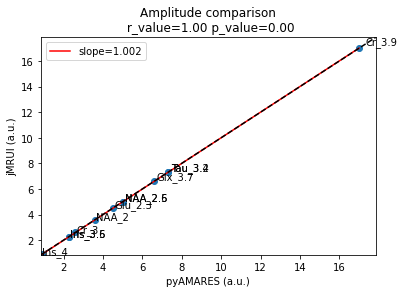

(1.0015735641341859, 0.9999905778878695, 5.847700001798031e-25)

In [31]:
compare_plot(x=df_reordered2['amplitude'], 
             y=detailedresults['Amplitude'],
             labellist=df_reordered2.index.to_list(), title='Amplitude comparison\n', 
             xlabel='pyAMARES (a.u.)', ylabel='jMRUI (a.u.)' )

- The CRLB (%), or sd/amplitude*100, shows very similar values between the tools. However, pyAMARES reports slightly lower CRLB values, as indicated by a slope of 1.096.

Slope: 1.096
Pearson's R: 0.9663
P-value: 3.25e-07


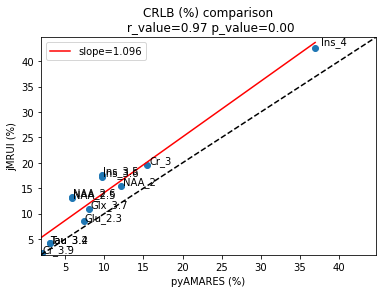

(1.0961043920100964, 0.9662767018870508, 3.2458845230544995e-07)

In [32]:

compare_plot(x=df_reordered2['CRLB(%)'] , 
             y=detailedresults['sd Ampl.']/detailedresults['Amplitude']*100,
             labellist=df_reordered2.index.to_list(), title='CRLB (%) comparison\n', 
             xlabel='pyAMARES (%)',
             ylabel='jMRUI (%)')

- Both tools report identical linewidth (Hz)

Slope: 1.013
Pearson's R: 0.9998
P-value: 5.76e-18


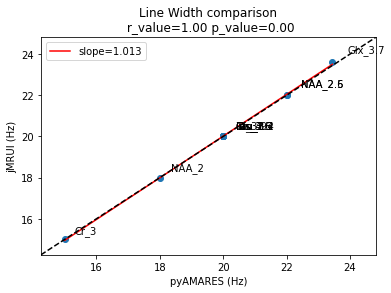

(1.0125348503618228, 0.9997639907514843, 5.764011462496292e-18)

In [33]:
compare_plot(
             x=df_reordered1['LW(Hz)'], 
             y=detailedresults['Sp. Width (Hz)'], 
             labellist=df_reordered2.index.to_list(), title='Line Width comparison\n', 
             xlabel='pyAMARES (Hz)',
             ylabel='jMRUI (Hz)')

**Conclusion:** Using the same prior knowledge datasets, pyAMARES delivers fitting results that are identical to those obtained with jMRUI.

**Visualizing MM Spectra with Residual Metabolites Removed by jMRUI and pyAMARES**

In [34]:
residual, header, str_info = jmrui.read_mrui('attachment/20240519_residual.mrui')
residual.shape

(4096,)

- Weight the jMRUI's residual for direct comparison with pyAMARES.

In [35]:
residual2 = np.conj(residual * apod) # conj() flips the ppm axis to be compatible with pyAMARES

- Shift the JMRUI residual to align the water peak at 4.7 ppm for comparison with the residual obtained by Method 1:

In [36]:
residual_fid_mrui_shifted = residual2 * np.exp(1j * 2 * np.pi * carrier * FIDresult1b.MHz * FIDresult1b.timeaxis)

In [37]:
residual_spec = np.fft.fftshift(np.fft.fft(residual_fid_mrui_shifted))
residual_spec_pyamares1 = np.fft.fftshift(np.fft.fft(FIDresult1b.residual)) # FFT the residual

Text(0.5, 1.0, 'Metabolite-Free MM Spectra, jMRUI vs pyAMARES (method1: shift FID)')

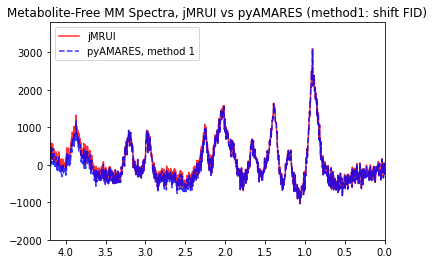

In [38]:
plt.plot(FIDresult1b.ppm, np.real(residual_spec), 'r-', alpha=0.8, label='jMRUI')
plt.plot(FIDresult1b.ppm, -1 * np.real(residual_spec_pyamares1), 'b--', alpha=0.8, label='pyAMARES, method 1')
plt.xlim(4.2, 0)
plt.ylim(-2000,3800)
plt.legend()
plt.title('Metabolite-Free MM Spectra, jMRUI vs pyAMARES (method1: shift FID)')

- The jMRUI residual can be directly compared to the residual obtained by Method 2, which shifts the peak positions defined in the prior knowledge.

In [39]:
residual_spec2 = np.fft.fftshift(np.fft.fft(residual2))
residual_spec_pyamares2 = np.fft.fftshift(np.fft.fft(FIDresult2b.residual)) 

Text(0.5, 1.0, 'Metabolite-Free MM spectra, jMRUI vs pyAMARES (method 2: shift Prior Knowledge)')

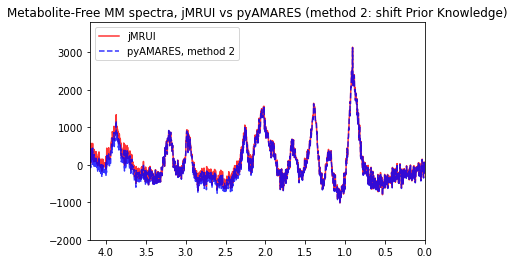

In [40]:
plt.plot(FIDresult1b.ppm+4.7, np.real(residual_spec2), 'r-', alpha=0.8, label='jMRUI')
plt.plot(FIDresult1b.ppm+4.7, -1 * np.real(residual_spec_pyamares2), 'b--', alpha=0.8, label='pyAMARES, method 2')
plt.xlim(4.2, 0)
plt.ylim(-2000,3800)
plt.legend()
plt.title('Metabolite-Free MM spectra, jMRUI vs pyAMARES (method 2: shift Prior Knowledge)')

**Conclusion:** The residual spectra with metabolite signals eliminated, obtained by both jMRUI and pyAMARES, are identical.